In [3]:
# Original Coding process

import sqlite3 
import pandas as pd

# Connecting to database.db
conn = sqlite3.connect('/Users/diboshbaruah/Desktop/Database.db')
data = pd.read_sql_query('SELECT * FROM Fraud_Detection', conn)

print("Displaying first few rows of the dataset")
print()
print(data.head())
print()

# Checking for data types
print("Data types before conversion:")
print(data.dtypes)

# Closing the connection
conn.close()


Displaying first few rows of the dataset

  step      type    amount     nameOrig oldbalanceOrg newbalanceOrig  \
0    1   PAYMENT   9839.64  C1231006815      170136.0      160296.36   
1    1   PAYMENT   1864.28  C1666544295       21249.0       19384.72   
2    1  TRANSFER     181.0  C1305486145         181.0            0.0   
3    1  CASH_OUT     181.0   C840083671         181.0            0.0   
4    1   PAYMENT  11668.14  C2048537720       41554.0       29885.86   

      nameDest oldbalanceDest newbalanceDest isFraud isFlaggedFraud  
0  M1979787155            0.0            0.0       0              0  
1  M2044282225            0.0            0.0       0              0  
2   C553264065            0.0            0.0       1              0  
3    C38997010        21182.0            0.0       1              0  
4  M1230701703            0.0            0.0       0              0  

Data types before conversion:
step              object
type              object
amount            object

In [5]:
# Data Pre-processing

# List of numeric columns that needs to be converted to numeric types
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Converting the columns listed in `numeric_columns` to numeric type using pandas `apply` method
# `errors='coerce'` will convert any non-numeric values to NaN
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Converting the 'step' column to numeric type. 
data['step'] = pd.to_numeric(data['step'], errors='coerce')

# Droping the columns 'nameOrig' and 'nameDest' as they represent unique identifiers
data.drop(columns=['nameOrig', 'nameDest'], inplace=True)

# Converting the categorical column 'type' to one-hot encoded features.
data = pd.get_dummies(data, columns=['type'], drop_first=True)

# Converting the new binary columns created from 'type' to integer type (1 or 0)
type_columns = ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
data[type_columns] = data[type_columns].astype(int)

# Converting the 'isFraud' column to integer type to represent whether the transaction is fraudulent (1) or not (0).
data['isFraud'] = data['isFraud'].astype(int)

# Converting the 'isFlaggedFraud' column to integer type to represent whether the transaction is flagged as potentially fraudulent (1) or not (0).
data['isFlaggedFraud'] = data['isFlaggedFraud'].astype(int)

print("Data Pre-processing completed successfully...")


Data Pre-processing completed successfully...


In [8]:
print("Displaying first few rows of the dataset post conversion")
print()
print(data.head())

# Checking the data types again after encoding
print("\nData types after Encoding:")
print(data.dtypes)


Displaying first few rows of the dataset post conversion

   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_IN  type_CASH_OUT  \
0             0.0        0               0             0              0   
1             0.0        0               0             0              0   
2             0.0        1               0             0              0   
3             0.0        1               0             0              1   
4             0.0        0               0             0              0   

   type_DEBIT  type_PAYMENT  type_TRANSFER  
0           0             1          

In [7]:
# Checking for missing values after encoding
print("Missing values in each column:")
print(data.isnull().sum())


Missing values in each column:
step                   0
amount                 0
oldbalanceOrg          0
newbalanceOrig    267230
oldbalanceDest    203603
newbalanceDest         0
isFraud                0
isFlaggedFraud         0
type_CASH_IN           0
type_CASH_OUT          0
type_DEBIT             0
type_PAYMENT           0
type_TRANSFER          0
dtype: int64


Skewness of Numerical Columns:
amount            30.993949
oldbalanceOrg      5.249136
newbalanceOrig     5.176528
oldbalanceDest    20.093165
newbalanceDest    19.352302
dtype: float64



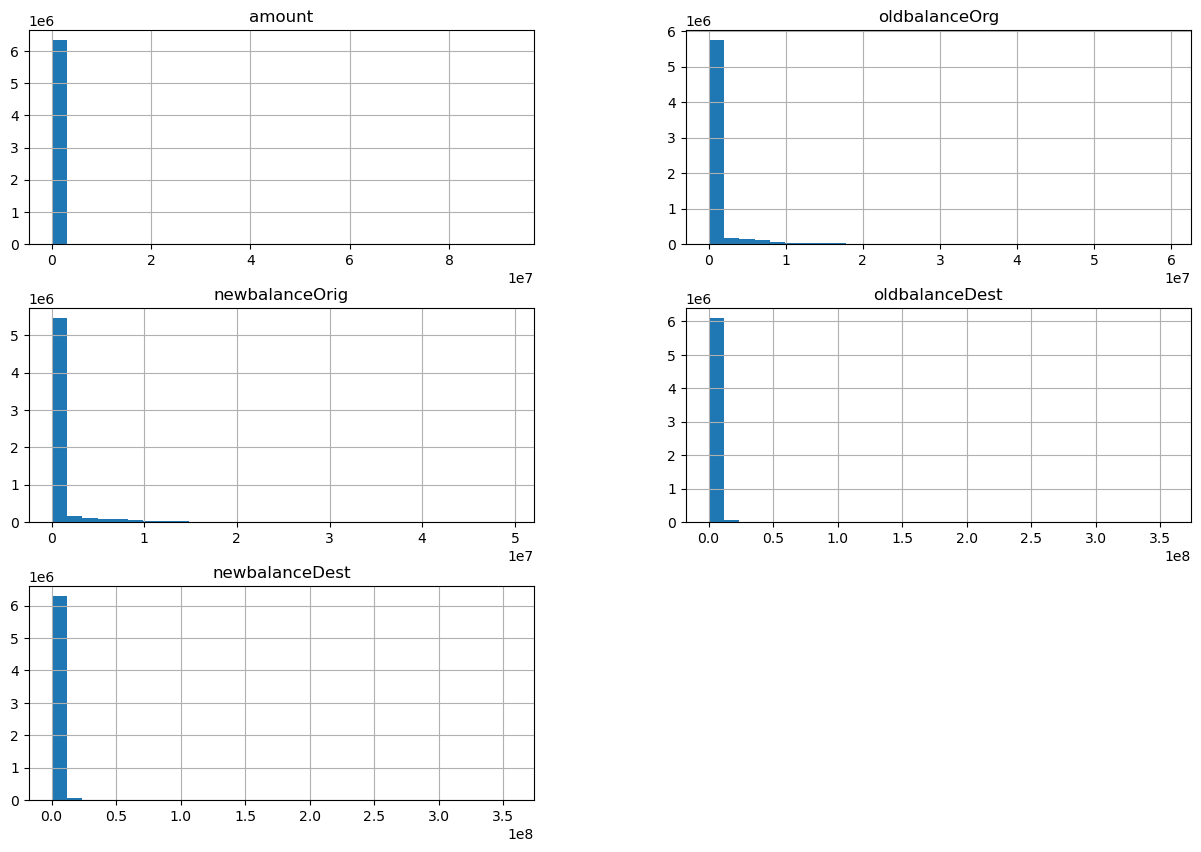

In [9]:
# Calculating skewness for numerical columns
import matplotlib.pyplot as plt

skewness = data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].skew()
print("Skewness of Numerical Columns:")
print(skewness)
print()

# Plotting histograms for numerical columns
data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].hist(bins=30, figsize=(15, 10))
plt.show()


In [11]:
import numpy as np
from sklearn.impute import SimpleImputer

# Handling missing values using median imputation for skewed columns
imputer = SimpleImputer(strategy='median')
data[['newbalanceOrig', 'oldbalanceDest']] = imputer.fit_transform(data[['newbalanceOrig', 'oldbalanceDest']])

# Re-checking missing values after imputation
print("Missing values after imputation:")
print(data[numeric_columns].isnull().sum())


Missing values after imputation:
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
dtype: int64


In [13]:
# Model Train-Test

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import joblib

# Splitting data into train, validation, and live sets
train_data = data.iloc[:4000000]
validation_data = data.iloc[4000000:5000000]
live_data = data.iloc[5000000:]

# Defining feature sets and targets
X_train = train_data.drop(columns=['isFraud', 'isFlaggedFraud'])
y_train = train_data['isFraud']

X_validation = validation_data.drop(columns=['isFraud', 'isFlaggedFraud'])
y_validation = validation_data['isFraud']

print()
print("Model Training started using XGBoost...")
print()

# Training the XGBoost model
model = xgb.XGBClassifier(
    eval_metric='logloss', 
    n_estimators=100, 
    max_depth=6, 
    learning_rate=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8 
) 
model.fit(X_train, y_train)



Model Training started using XGBoost...



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Classification Report on Validation Dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    999446
           1       0.97      0.68      0.80       554

    accuracy                           1.00   1000000
   macro avg       0.99      0.84      0.90   1000000
weighted avg       1.00      1.00      1.00   1000000


ROC AUC Score (default threshold): 0.9995952170860057

F1-score: 0.7987220447284346

Confusion Matrix:
[[999436     10]
 [   179    375]]
Precision-Recall AUC: 0.8305181811092267


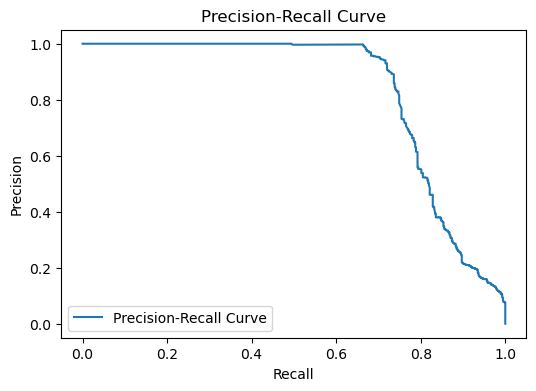


Feature Importance:
           Feature  Importance
5   newbalanceDest    0.175419
3   newbalanceOrig    0.171088
7    type_CASH_OUT    0.147731
6     type_CASH_IN    0.125227
2    oldbalanceOrg    0.104398
9     type_PAYMENT    0.081312
4   oldbalanceDest    0.056599
1           amount    0.055111
0             step    0.038399
10   type_TRANSFER    0.036067
8       type_DEBIT    0.008649


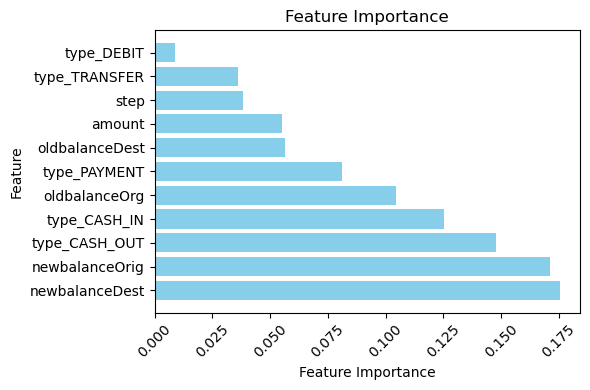

Trained model is saved!!


In [15]:
# Model Prediction and evaluation

y_pred_eval = model.predict(X_validation)
y_pred_prob = model.predict_proba(X_validation)[:, 1]

print("Classification Report on Validation Dataset:")
print(classification_report(y_validation, y_pred_eval))

print()
print("ROC AUC Score (default threshold):", roc_auc_score(y_validation, y_pred_prob))

print()
print("F1-score:", f1_score(y_validation, y_pred_eval))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_pred_eval))

# Calculating precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_validation, y_pred_prob)
auc_pr = auc(recall, precision)
print("Precision-Recall AUC:", auc_pr)

# Plotting Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Getting feature importances
feature_importances = model.feature_importances_

# Creating a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance_df)

# Setting the figure size
plt.figure(figsize=(6, 4))

# Creatting a bar chart for feature importance
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')

# Setting labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Showing the plot
plt.tight_layout()
plt.show()

# Saving the trained model
joblib.dump(model, 'fraud_model.xgb')
print("Trained model is saved!!")


** Now running the saved scripts on jupyter notebook - train_model.py // predict_fraud.py // app.py ***

In [4]:
# Importing the training script
!python train_model.py


Classification Report on Validation Dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    999446
           1       0.98      0.69      0.81       554

    accuracy                           1.00   1000000
   macro avg       0.99      0.84      0.90   1000000
weighted avg       1.00      1.00      1.00   1000000

ROC AUC Score (default threshold): 0.9996516246896088
F1-score: 0.8084656084656084
Confusion Matrix:
[[999437      9]
 [   172    382]]
Trained model is saved!!


In [6]:
# Importing the Predict script
!python predict_model.py


Predictions on live data:
[0 0 1 ... 1 1 1]


In [8]:
import subprocess

# Now running the Flask app using subprocess
subprocess.Popen(["python", "app.py"])


<Popen: returncode: None args: ['python', 'app.py']>

In [30]:
import requests
import json

# The URL for the Flask API endpoint
url = "http://127.0.0.1:5000/predict"

# Sample data to send for prediction (without 'nameDest' and 'nameOrig')
# Here, the `type` column is used, which will be one-hot encoded in the API
data = {
    "step": [5],
    "type": ["PAYMENT"],  # This is the original type column; it will be one-hot encoded in the API
    "amount": [9839.64],
    "oldbalanceOrg": [170136.0],
    "newbalanceOrig": [160296.36],
    "oldbalanceDest": [0.0],
    "newbalanceDest": [0.0]
}

# Send POST request with data
response = requests.post(url, json=data)

# Check the response
if response.status_code == 200:
    # If request is successful, print the prediction
    print("Prediction received:", response.json())
else:
    # If there's an error, print the error message
    print("Error:", response.json())


Prediction received: {'prediction': [0]}


127.0.0.1 - - [03/Jan/2025 10:53:58] "POST /predict HTTP/1.1" 200 -
